In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
# pip install -q -U tensorflow-addons

In [3]:
# import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D,LocallyConnected1D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization,Add,concatenate
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [5]:
# The number of steps within one time segment
TIME_PERIODS = 10000
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 10000
N_FEATURES = 12

In [6]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'Class_label']


In [7]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [8]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [9]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [10]:
 pd.options.display.float_format = "{:,.5f}".format

In [11]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [12]:
verbose, epochs, batch_size = 0, 300, 16

In [13]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.1
   epochs_drop = 40.0
   lrate = initial_lrate * tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
   return lrate

In [14]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
test_acc=[]

In [15]:
# import os
path='/media/naveen/nav/mat_codes/nina_DB2_codes/preprocess/Total_process_TT/'

In [16]:
#  for i in range(num_res_net_blocks_64):
#     x = res_net_block_64(x, 64, 3)

In [17]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'nina_pro_DB2_Train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/nina_DB2_codes/preprocess/Total_process_TT/nina_pro_DB2_Train.csv


In [18]:
file_path_test=path+'nina_pro_DB2_Test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/nina_DB2_codes/preprocess/Total_process_TT/nina_pro_DB2_Test.csv


In [19]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 13
Number of rows in the dataframe: 78400000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class_label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
2,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,1.00000
3,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,1.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


In [20]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 13
Number of rows in the dataframe: 39200000



,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,Class_label
0,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,0.00000,0.00000,0.00001,1.00000
1,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00001,0.00000,0.00000,0.00000,0.00002,1.00000
2,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00002,1.00000
3,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00002,1.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00002,1.00000


In [21]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [22]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (7839, 10000, 12)
7839 training samples
y_train shape:  (7839,)
num_time_periods 10000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (10000, 12)
input_shape: (10000, 12)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
New y_train shape:  (7839, 49)


In [23]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (3919, 10000, 12)
3919 testing samples
y_test shape:  (3919,)


In [24]:
# # n_steps, n_length = 20, 25
# # n_steps, n_length= 10, 50
# # n_steps, n_length= 16, 32
# n_sub,n_steps, n_length = 25, 400, 12
# n_depth=1
# x_train = x_train.reshape(x_train.shape[0],n_sub,n_steps, n_length)
# print('x_train shape: ', x_train.shape)
# # x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# # print('x_valid shape: ', x_valid.shape)
# x_test = x_test.reshape(x_test.shape[0], n_sub,n_steps, n_length)
# print('x_test shape: ', x_test.shape)
# n_outputs = y_train_hot.shape[1]
# print('n_outputs',n_outputs)

In [25]:
# n_steps, n_length = 20, 25
# n_steps, n_length= 10, 50
# n_steps, n_length= 16, 32
n_sub,n_steps, n_length = 25, 400, 12
n_depth=1
x_train = x_train.reshape(x_train.shape[0],n_sub,n_steps, n_length, n_depth)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_sub,n_steps, n_length, n_depth)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
print('n_outputs',n_outputs)

x_train shape:  (7839, 25, 400, 12, 1)
x_test shape:  (3919, 25, 400, 12, 1)
n_outputs 49


In [26]:
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(9,1), padding='same', kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04), \
#                            input_shape=(n_sub,n_steps,n_length)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Conv2D(filters=32, kernel_size=(3,3),padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04)))
# model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size=(3,3),strides=1))
# model.add(Conv2D(filters=64, kernel_size=(5,5),padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(AveragePooling2D(pool_size=(3,3),strides=1))
# model.add(Conv2D(filters=64, kernel_size=(5,5),padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04)))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(n_outputs, activation='softmax'))

In [27]:
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=32, kernel_size=12, padding='same', kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04)), \
#                            input_shape=(n_sub,n_steps, n_length)))
# model.add(TimeDistributed(Activation('relu')))
# # model.add(TimeDistributed(Dropout(0.5)))
# model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3,padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04))))
# model.add(TimeDistributed(Activation('relu')))
# model.add(TimeDistributed(AveragePooling1D(pool_size=3,strides=1)))
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04))))
# model.add(TimeDistributed(Activation('relu')))
# model.add(TimeDistributed(Dropout(0.5)))
# model.add(TimeDistributed(AveragePooling1D(pool_size=3,strides=1)))
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=9,padding="same",kernel_initializer="he_normal",strides=1,kernel_regularizer=l2(1e-04))))
# model.add(TimeDistributed(Activation('relu')))
# model.add(TimeDistributed(Dropout(0.5)))
# model.add(Flatten())
# model.add(Dense(n_outputs, activation='softmax'))

In [67]:
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(12,1), padding='same', kernel_initializer="he_normal",strides=(3,1),kernel_regularizer=l1(1e-04)), \
                           input_shape=(n_sub,n_steps,n_length,n_depth)))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3),padding="same",kernel_initializer="he_normal",strides=(1,1),kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(AveragePooling2D(pool_size=(3,3),strides=1)))
model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(5,5),padding="same",kernel_initializer="he_normal",strides=(1,1),kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(AveragePooling2D(pool_size=(3,3),strides=1)))
model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(9,1),padding="same",kernel_initializer="he_normal",strides=(1,1),kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Activation('relu')))
model.add(Flatten())
# model.add(Dense(512, activation='tanh'))
model.add(Dense(n_outputs, activation='softmax'))

In [68]:
# adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
sgd=tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=False, name='SGD')
checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_145 (TimeDi (None, 25, 134, 12, 32)   416       
_________________________________________________________________
time_distributed_146 (TimeDi (None, 25, 134, 12, 32)   128       
_________________________________________________________________
time_distributed_147 (TimeDi (None, 25, 134, 12, 32)   0         
_________________________________________________________________
time_distributed_148 (TimeDi (None, 25, 134, 12, 32)   0         
_________________________________________________________________
time_distributed_149 (TimeDi (None, 25, 134, 12, 32)   9248      
_________________________________________________________________
time_distributed_150 (TimeDi (None, 25, 134, 12, 32)   128       
_________________________________________________________________
time_distributed_151 (TimeDi (None, 25, 134, 12, 32)  

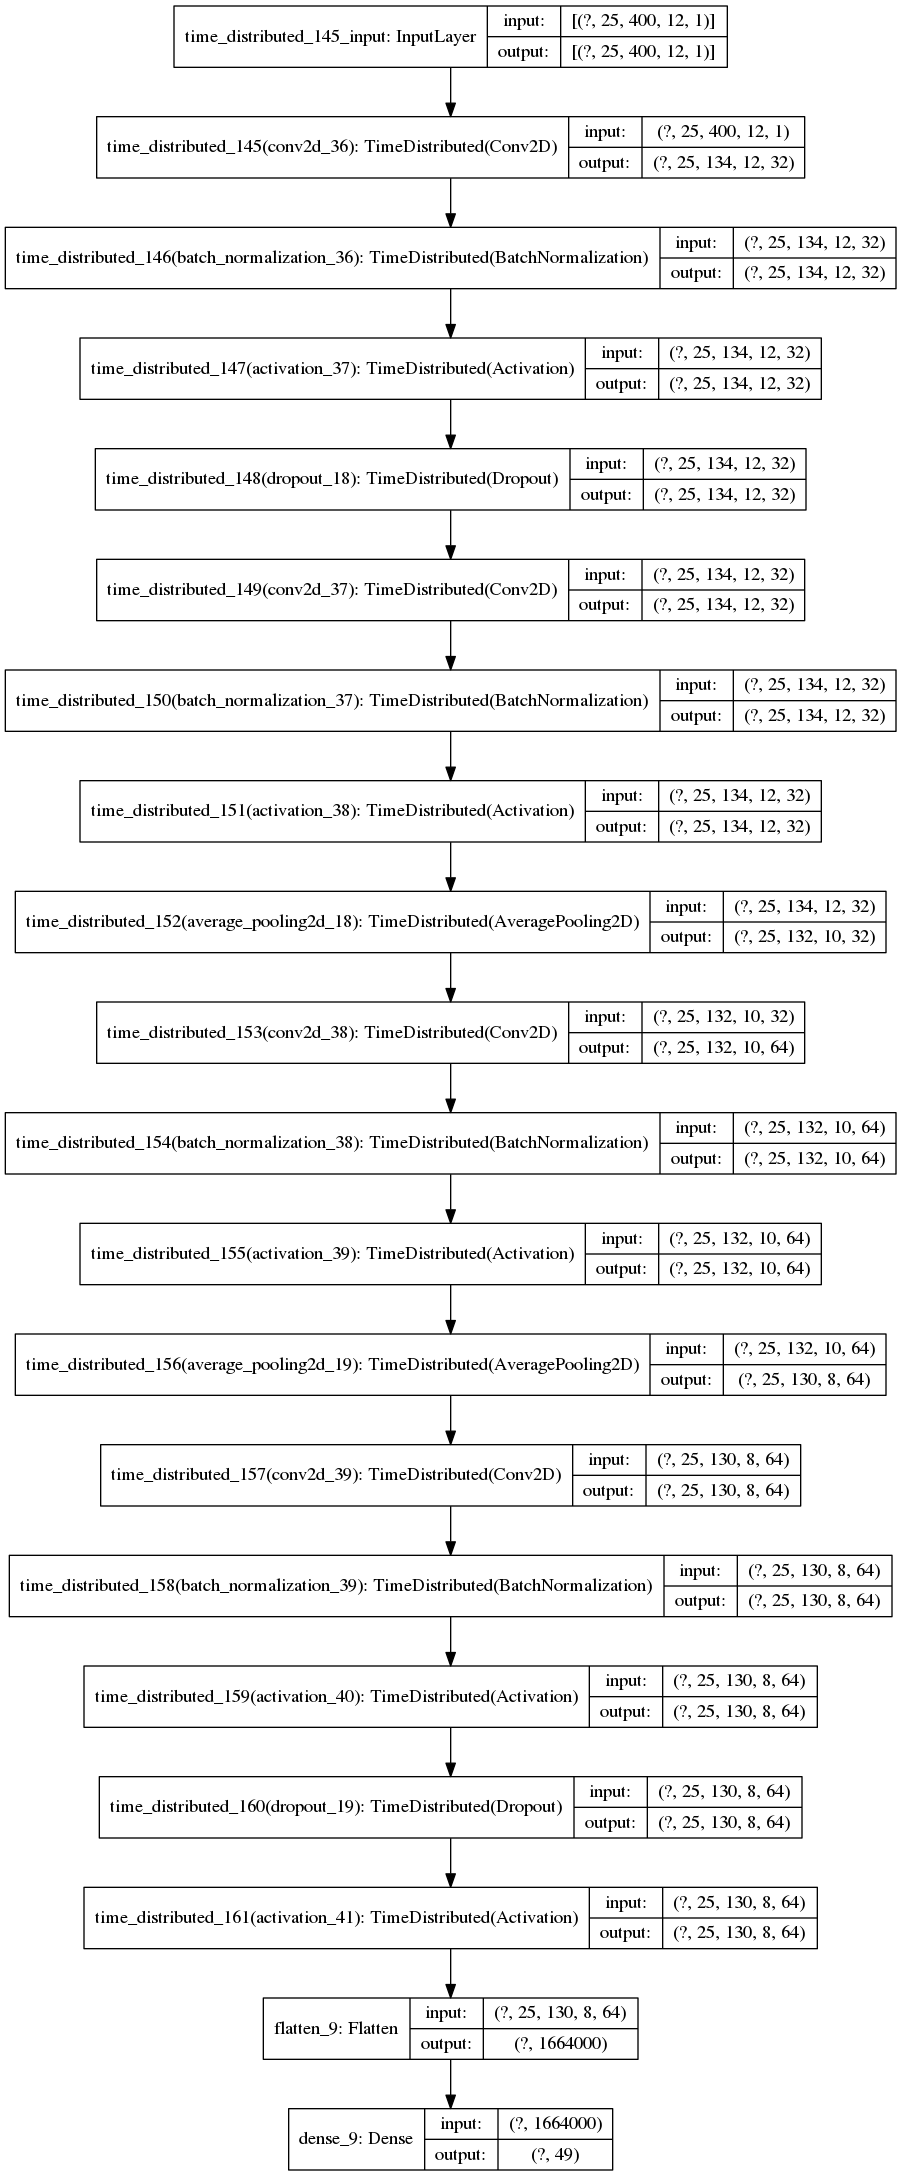

In [69]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/CNN100X100/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [ ]:
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)

Epoch 1/300
490/490 [==============================] - ETA: 0s - loss: 11.6753 - accuracy: 0.1467
Epoch 00001: val_accuracy improved from -inf to 0.12044, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/checkpoint.hdf5
490/490 [==============================] - 48s 98ms/step - loss: 11.6753 - accuracy: 0.1467 - val_loss: 5.0378 - val_accuracy: 0.1204 - lr: 0.0010
Epoch 2/300
490/490 [==============================] - ETA: 0s - loss: 2.6835 - accuracy: 0.3927
Epoch 00002: val_accuracy did not improve from 0.12044
490/490 [==============================] - 45s 92ms/step - loss: 2.6835 - accuracy: 0.3927 - val_loss: 6.7329 - val_accuracy: 0.0577 - lr: 0.0010
Epoch 3/300
490/490 [==============================] - ETA: 0s - loss: 2.2320 - accuracy: 0.5008
Epoch 00003: val_accuracy improved from 0.12044 to 0.45700, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/checkpoint.hdf5
490/490 [==============================] - 47s 96ms/step - loss: 2.2320

Epoch 26/300
490/490 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.9760
Epoch 00026: val_accuracy did not improve from 0.56060
490/490 [==============================] - 44s 90ms/step - loss: 0.4880 - accuracy: 0.9760 - val_loss: 2.2634 - val_accuracy: 0.5438 - lr: 0.0010
Epoch 27/300
490/490 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.9814
Epoch 00027: val_accuracy improved from 0.56060 to 0.56366, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/atzori_DB2/checkpoint.hdf5
490/490 [==============================] - 47s 97ms/step - loss: 0.4737 - accuracy: 0.9814 - val_loss: 2.1416 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 28/300
490/490 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.9792
Epoch 00028: val_accuracy did not improve from 0.56366
490/490 [==============================] - 47s 95ms/step - loss: 0.4687 - accuracy: 0.9792 - val_loss: 2.2247 - val_accuracy: 0.5471 - lr: 0.0010
Epoch 29/300

Epoch 53/300
490/490 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.9954
Epoch 00053: val_accuracy did not improve from 0.56928
490/490 [==============================] - 44s 90ms/step - loss: 0.3541 - accuracy: 0.9954 - val_loss: 2.1284 - val_accuracy: 0.5634 - lr: 1.0000e-04
Epoch 54/300
490/490 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.9962
Epoch 00054: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3552 - accuracy: 0.9962 - val_loss: 2.1222 - val_accuracy: 0.5609 - lr: 1.0000e-04
Epoch 55/300
490/490 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.9958
Epoch 00055: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3519 - accuracy: 0.9958 - val_loss: 2.1418 - val_accuracy: 0.5588 - lr: 1.0000e-04
Epoch 56/300
490/490 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 

490/490 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.9955
Epoch 00080: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3398 - accuracy: 0.9955 - val_loss: 2.1610 - val_accuracy: 0.5586 - lr: 1.0000e-05
Epoch 81/300
490/490 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.9971
Epoch 00081: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3365 - accuracy: 0.9971 - val_loss: 2.1251 - val_accuracy: 0.5642 - lr: 1.0000e-05
Epoch 82/300
490/490 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.9959
Epoch 00082: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3409 - accuracy: 0.9959 - val_loss: 2.1067 - val_accuracy: 0.5677 - lr: 1.0000e-05
Epoch 83/300
490/490 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.9971
Epoch 

490/490 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.9972
Epoch 00107: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3381 - accuracy: 0.9972 - val_loss: 2.1340 - val_accuracy: 0.5634 - lr: 1.0000e-05
Epoch 108/300
490/490 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.9969
Epoch 00108: val_accuracy did not improve from 0.56928
490/490 [==============================] - 44s 90ms/step - loss: 0.3377 - accuracy: 0.9969 - val_loss: 2.0979 - val_accuracy: 0.5688 - lr: 1.0000e-05
Epoch 109/300
490/490 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.9964
Epoch 00109: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3371 - accuracy: 0.9964 - val_loss: 2.1194 - val_accuracy: 0.5626 - lr: 1.0000e-05
Epoch 110/300
490/490 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.9962
Epo

Epoch 134/300
490/490 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.9977
Epoch 00134: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3369 - accuracy: 0.9977 - val_loss: 2.1254 - val_accuracy: 0.5626 - lr: 1.0000e-06
Epoch 135/300
490/490 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.9967
Epoch 00135: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3364 - accuracy: 0.9967 - val_loss: 2.1117 - val_accuracy: 0.5652 - lr: 1.0000e-06
Epoch 136/300
490/490 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.9971
Epoch 00136: val_accuracy did not improve from 0.56928
490/490 [==============================] - 42s 86ms/step - loss: 0.3348 - accuracy: 0.9971 - val_loss: 2.1401 - val_accuracy: 0.5616 - lr: 1.0000e-06
Epoch 137/300
490/490 [==============================] - ETA: 0s - loss: 0.3354 - accura

In [ ]:
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])

In [ ]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)
test_acc.append(testaccuracy)
print(test_acc)

In [ ]:
statistics.mean(test_acc)